# Visualization of CNN Layers and Filters

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch 
import torch.nn as nn
import torchvision
#import datasets in torchvision
import torchvision.datasets as datasets
import os

#import model zoo in torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import torch.utils.data as data
from PIL import Image

## Load dataset

In [3]:
# Root directory for dataset
data_root = "/home/mehmetyavuz/datasets/CelebA128/"
attr_root = "/home/mehmetyavuz/datasets/list_attr_celeba.txt"
# Number of workers for dataloader
batch_size = 64
workers = 8
image_size = (128,128)

In [4]:
class CelebA(data.Dataset):
    def __init__(self, data_path, attr_path, image_size, mode, selected_attrs):
        super(CelebA, self).__init__()
        self.data_path = data_path
        att_list = open(attr_path, 'r', encoding='utf-8').readlines()[1].split()
        atts = [att_list.index(att) + 1 for att in selected_attrs]
        images = np.loadtxt(attr_path, skiprows=2, usecols=[0], dtype=np.str)
        labels = np.loadtxt(attr_path, skiprows=2, usecols=atts, dtype=np.int)
        
        self.tf = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ])
        if mode == 'train':
            self.images = images[:162770]
            self.labels = labels[:162770]

        if mode == 'valid':
            self.images = images[162770:182637]
            self.labels = labels[162770:182637]

        if mode == 'test':
            self.images = images[182637:]
            self.labels = labels[182637:]
                                       
        self.length = len(self.images)
    def __getitem__(self, index):
        img = self.tf(Image.open(os.path.join(self.data_path, self.images[index])))
        att = torch.tensor((self.labels[index] + 1) // 2)
        return img, att.to(torch.float32)
    def __len__(self):
        return self.length

In [5]:
attrs_default = ["5_o_Clock_Shadow", "Arched_Eyebrows", "Attractive", "Bags_Under_Eyes", "Bald", "Bangs", "Big_Lips", "Big_Nose", 
                 "Black_Hair", "Blond_Hair", "Blurry", "Brown_Hair", "Bushy_Eyebrows", "Chubby", "Double_Chin", "Eyeglasses", "Goatee", 
                 "Gray_Hair", "Heavy_Makeup", "High_Cheekbones", "Male", "Mouth_Slightly_Open", "Mustache", "Narrow_Eyes", "No_Beard", 
                 "Oval_Face", "Pale_Skin", "Pointy_Nose", "Receding_Hairline", "Rosy_Cheeks", "Sideburns", "Smiling", "Straight_Hair", 
                 "Wavy_Hair", "Wearing_Earrings", "Wearing_Hat", "Wearing_Lipstick", "Wearing_Necklace", "Wearing_Necktie", "Young"]

In [6]:
dataset = CelebA(data_root, attr_root, image_size, 'test', attrs_default)
evalloader = torch.utils.data.DataLoader(dataset,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          num_workers=workers)

## Load pretrained model

In [7]:
model = models.__dict__['alexnet'](pretrained=False)
model.classifier[6] = nn.Linear(4096,40,bias=True)
model = torch.nn.DataParallel(model)
model.cuda()

DataParallel(
  (module): AlexNet(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
    (classifier): Sequential(
      (0): Dropout(p=0.5, inplace=False)
   

## Visualise image

## Occlusion analysis

## Filter visualisation

In [8]:
def plot_filters_single_channel_big(t):
    
    #setting the rows and columns
    nrows = t.shape[0]*t.shape[2]
    ncols = t.shape[1]*t.shape[3]
    
    
    npimg = np.array(t.numpy(), np.float32)
    npimg = npimg.transpose((0, 2, 1, 3))
    npimg = npimg.ravel().reshape(nrows, ncols)
    
    npimg = npimg.T
    
    fig, ax = plt.subplots(figsize=(ncols/10, nrows/200))    
    imgplot = sns.heatmap(npimg, xticklabels=False, yticklabels=False, cmap='gray', ax=ax, cbar=False)

In [9]:
def plot_filters_single_channel(t):
    
    #kernels depth * number of kernels
    nplots = t.shape[0]*t.shape[1]
    ncols = 16
    
    nrows = 1 + nplots//ncols
    #convert tensor to numpy image
    npimg = np.array(t.cpu().numpy(), np.float32)
    
    count = 0
    fig = plt.figure(figsize=(ncols, nrows))
    
    #looping through all the kernels in each channel
    for i in range(t.shape[0]):
        for j in range(t.shape[1]):
            count += 1
            ax1 = fig.add_subplot(nrows, ncols, count)
            npimg = np.array(t[i, j].cpu().numpy(), np.float32)
            npimg = (npimg - np.mean(npimg)) / np.std(npimg)
            npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
            ax1.imshow(npimg)
            ax1.axis('off')
            ax1.set_xticklabels([])
            ax1.set_yticklabels([])
   
    plt.tight_layout()
    plt.show()

In [10]:
def plot_filters_multi_channel(t):
    
    #get the number of kernals
    num_kernels = t.shape[0]    
    
    #define number of columns for subplots
    num_cols = 8
    #rows = num of kernels
    num_rows = num_kernels
    
    #set the figure size
    fig = plt.figure(figsize=(num_cols,num_rows))
    
    #looping through all the kernels
    for i in range(t.shape[0]):
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)
        
        #for each kernel, we convert the tensor to numpy 
        npimg = np.array(t[i].cpu().numpy(), np.float32)
        #standardize the numpy image
        npimg = (npimg - np.mean(npimg)) / np.std(npimg)
        npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
        npimg = npimg.transpose((1, 2, 0))
        ax1.imshow(npimg)
        ax1.axis('off')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        
    plt.savefig('myimage.png', dpi=100)    
    plt.tight_layout()
    plt.show()

In [11]:
def plot_weights(model, layer_num, single_channel = True, collated = False):
  
  #extracting the model features at the particular layer number
  layer = model.module.features[layer_num]
  
  #checking whether the layer is convolution layer or not 
  if isinstance(layer, nn.Conv2d):
    #getting the weight tensor data
    weight_tensor = model.module.features[layer_num].weight.data
    
    if single_channel:
      if collated:
        plot_filters_single_channel_big(weight_tensor)
      else:
        plot_filters_single_channel(weight_tensor)
        
    else:
      if weight_tensor.shape[1] == 3:
        plot_filters_multi_channel(weight_tensor)
      else:
        print("Can only plot weights with three channels with single channel = False")
        
  else:
    print("Can only visualize layers which are convolutional")

In [12]:
model.eval()
weights = torch.load("alexnet_PD_100_0.pth")
model.load_state_dict(weights,strict=True)

<All keys matched successfully>

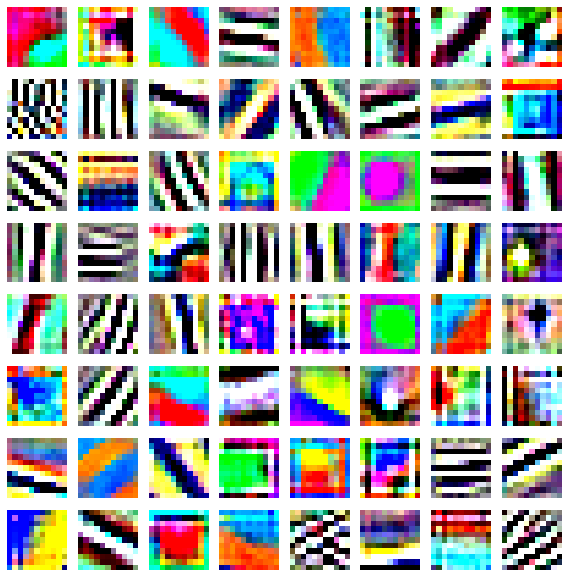

In [13]:
#visualize weights for alexnet - first conv layer

plot_weights(model, 0, single_channel = False)

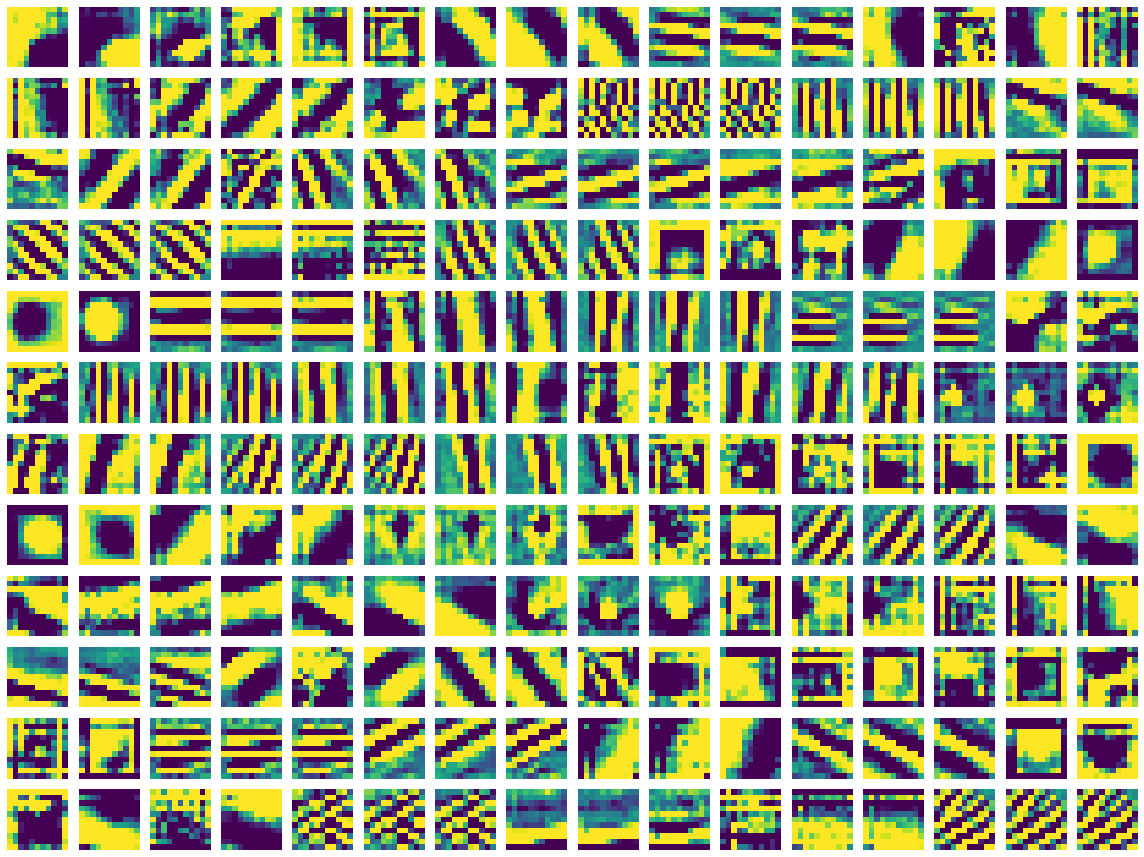

In [14]:
#plotting single channel images

plot_weights(model, 0, single_channel = True)